In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# End-to-End Multi-class dog breed classification

This notebook use Tensorflow (version 2.0) and Tensorflow Hub to build an end-to-end multi-class dog breed image classifier.

## 1. Problem
Identify the breed of a dog given an image

## 2. Data
The data we're using is from Kaggle
[Kaggle Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:
```
id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.
```

## 4. Features
Some information about the data:
* We're dealing with images (unstructured data) so it's porobably better if we use deep learning/ transfer learning
* There are 120 different classes (breeds of dogs)
* There are around 10'000+ images in the training set (these images have labels)
* There are around 10'000+ images in the test set (these images have no labels because we'll want to predict them)



In [ ]:
#unzip the file into the Google Drive
#!unzip "/content/drive/MyDrive/Dog Vision/dog-breed-identification.zip"

# Get our workspace ready

* import TensorFlow 2.x ✅
* import TensorFlow Hub ✅
* Make sure we're using a GPU ✅

In [ ]:
#import necessary tools

#import TensorFlow into Colab
import tensorflow as tf
print("TF version:", tf.__version__)

#import TensorFlow Hub
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)

#check GPU available
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.15.0
TF Hub version: 0.16.1
GPU not available


## Getting our data ready (turning into tensors)

with all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out labels.

In [ ]:
# checkout the lables of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: xlabel='breed'>

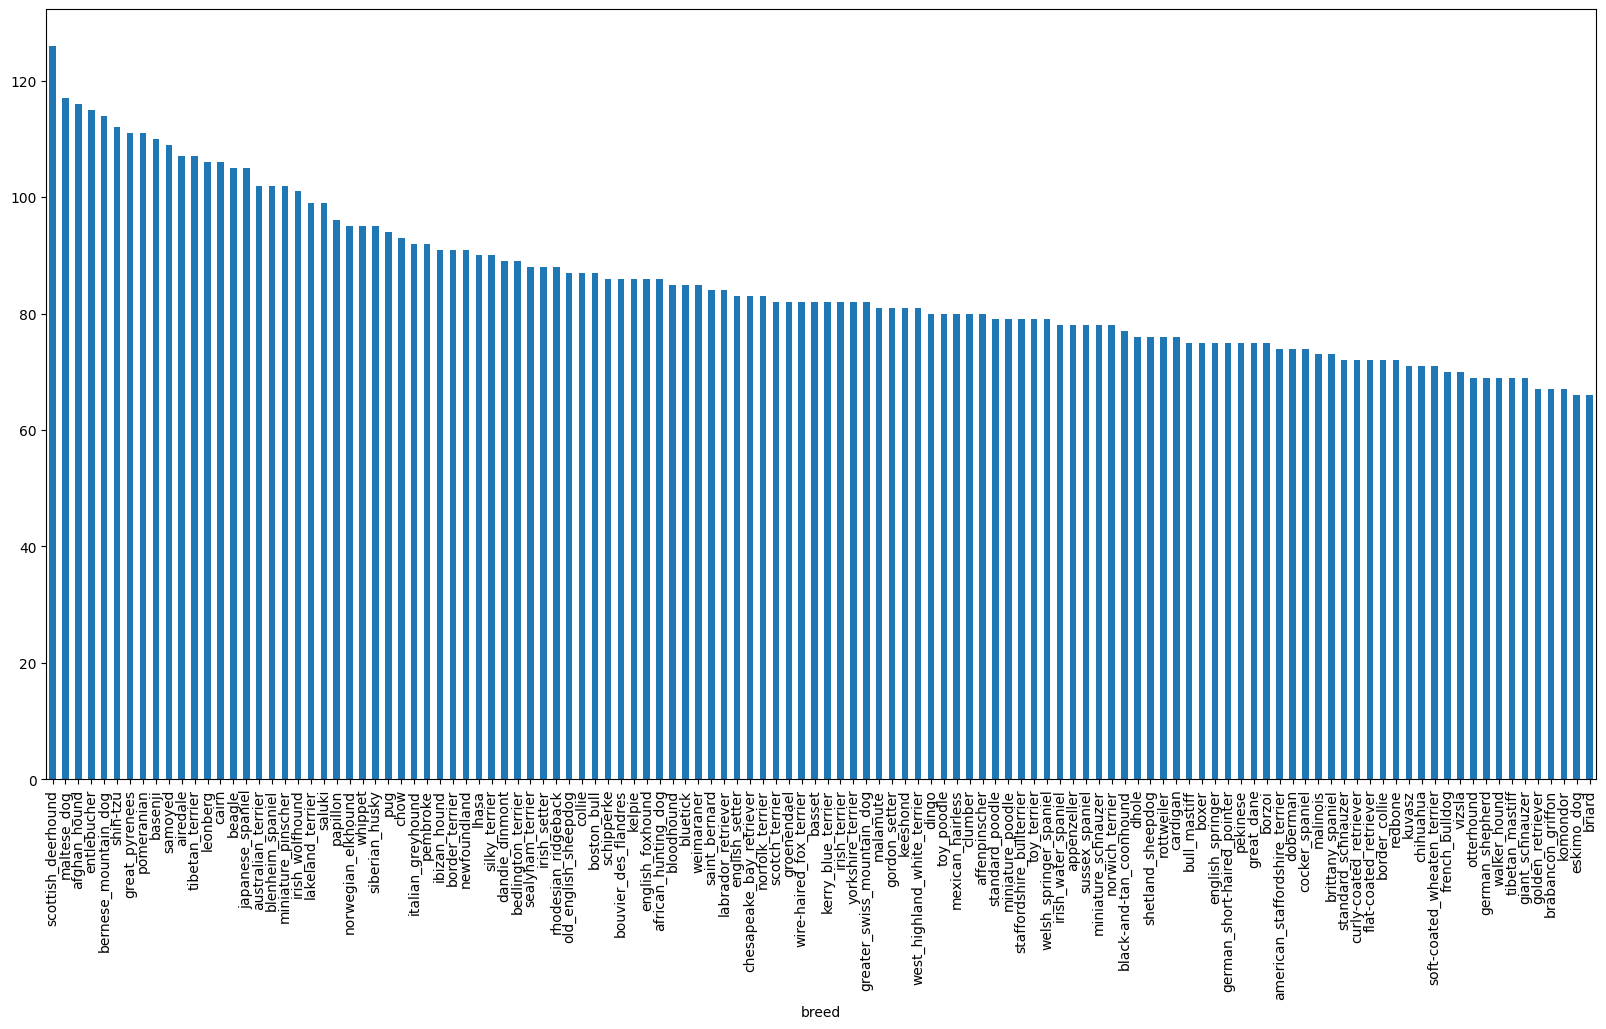

In [ ]:
# how many images are there of each breed? DISTRIBUTION OF OUR LABELS
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
# How many images per class? 82
labels_csv["breed"].value_counts().median()

82.0

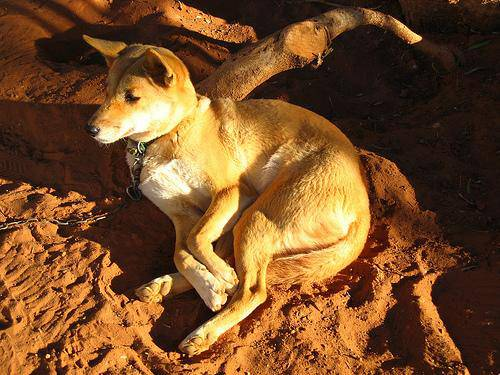

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all our image file pathnames

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# create pathname for image ID's
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# check the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

* os.listdir("drive/...") elenca tutti i file presenti nella directory indicata
* len(os.listdir) calcola il numero di file presenti nella directory
* len(filenames) calcola il numero di percorsi di file generati nel codice sopra
* IF: se il numero di file presenti nella directory corrisponde al numero di percorsi di file generati --> MATCH

In [ ]:
# check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

print(len(filenames))
print(len([f for f in os.listdir("drive/MyDrive/Dog Vision/train/") if f.endswith('.jpg')]))
print(len(labels_csv["id"]))

temp = ['drive/MyDrive/Dog Vision/train/' + f for f in os.listdir("drive/MyDrive/Dog Vision/train/") if f.endswith('.jpg')]
filenames1 = filenames

temp1 = [x for x in filenames1 if x not in temp] + [x for x in temp if x not in filenames1]
temp2 = [x for x in temp if x not in filenames1]
#print(filenames1[0])
#print(temp[0])

for x in temp2:
  print (x)

Filenames do not match actual amount of files, check the target directory.
10222
10234
10222
drive/MyDrive/Dog Vision/train/87001075188b63c8edeb2ffaf4cdfca4 (1).jpg
drive/MyDrive/Dog Vision/train/880379ffeea97e48cf12349753838a54 (1).jpg
drive/MyDrive/Dog Vision/train/8587cc1bb05b7997b4190485d07107a5 (1).jpg
drive/MyDrive/Dog Vision/train/889c421c15dfaa61b6d5ede5c2b31d17 (1).jpg
drive/MyDrive/Dog Vision/train/8e78aa56df01e3e6c29a6fa1f0b19575 (1).jpg
drive/MyDrive/Dog Vision/train/8e78fd35123e6824f396ca237700f853 (1).jpg
drive/MyDrive/Dog Vision/train/8e7d364f77c61d6721e1f574edc0d4e5 (1).jpg
drive/MyDrive/Dog Vision/train/8898c34ad05d2c95319ff2a2f326e69c (1).jpg
drive/MyDrive/Dog Vision/train/858e7823ed319c10e78d9df1f456ff7a (1).jpg
drive/MyDrive/Dog Vision/train/8700e299601a8aea94ad3e5e6094d2f0 (1).jpg
drive/MyDrive/Dog Vision/train/86f0e4abee677119258764eadc368b9d (1).jpg
drive/MyDrive/Dog Vision/train/858771bb039b3317f92b698874307126 (1).jpg


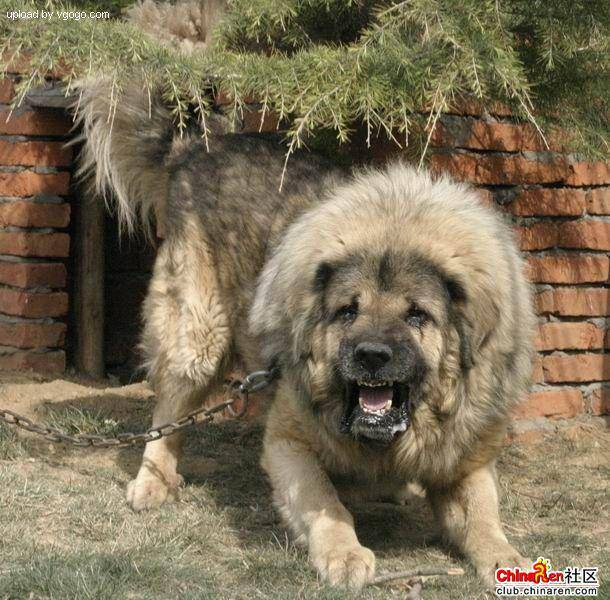

In [ ]:
# one more check
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels)== len(filenames):
  print("number of labels matches the number of filenames")
else:
  print("number of labels does not match number of filenames, check data directory")


number of labels matches the number of filenames


ML models can't take strings so we have to convert the labels (breeds of the dogs) into numbers.

To begin let's find a list of all the unique breeds.

In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels] #for each label in labels it rappresents it in boolean
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(labels)

10222

In [ ]:
len(boolean_labels)

10222

### Spiegazione codice sopra

1. Hai un array di etichette chiamato labels.
2. Crea un nuovo array chiamato boolean_labels.
3. Per ogni etichetta nell’array labels, verifica se l’etichetta è uguale a una delle etichette uniche (contenute in unique_breeds).
4. Se l’etichetta è uguale a una delle etichette uniche, imposta il valore corrispondente nell’array boolean_labels su True, altrimenti imposta il valore su False.

In [ ]:
# Example: turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

### Creating our own validation set
Since the dataset form Kaggle doesn't come with a validation set we're going to create our own.

In [ ]:
# setup X & y variables
X = filenames
y = boolean_labels


We're going to start off experimenting with 1000 images and increase as needed.

In [ ]:
# set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

#split them into train and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:5], y_train[:2] #X=path, y=boolean labels

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

## Preprocessing Images (**turning images into Tensors**)

To preprocess our images into Tensor we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensor
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (244, 244)
6. Return the modified `image`

Before we to, let's see what importing an image looks like

In [ ]:
# convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]], dtype=uint8)
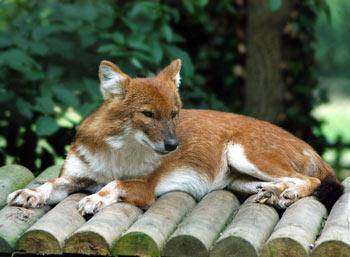

In [ ]:
image

In [ ]:
# turn an image into a tensor
tf.constant(image)[:2]
# the shape is different (257,350,3)-->(2,350,3)

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def  process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the jpg image into numerical tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # NORMALIZATION Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (244, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

### Turn data into Batches
- Or minibatch --> small portion of your data.

- 32 is the default batch size
(Yann Lecun batch size or Jeremy Howard)

Why turn it into batches?
Let's say you're trying to process 10.000+ images in one go: they all might not fit into memory.
That's why we do about 32 (batch size) images at a time (you can manually adjust it if you need).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples whick look like this:

`(image,label)`

In [ ]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Take an image file path name and the assosciated label,
  processes the image and returns a tuple of (image,label)
  """
  image=process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
((process_image(X[42]), y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

## Turn All Data into tuple of Tensors (batches)

Now we've got a way to turn our data into tuples of Tensor in the form: `(image, label)`.

Let's make a function to turn data into batches.

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, to make it easiest to understand let's visualize them.

In [ ]:
import matplotlib.pyplot as plt
#create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """

  #Setup the fiure
  plt.figure(figsize=(10,10))
  #Loop through 25 (for displaying 25 images)
  for i in range(25):
    #create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5, i+1)
    #Display an image
    plt.imshow(images[i])
    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn the grid lines off
    plt.axis("off")


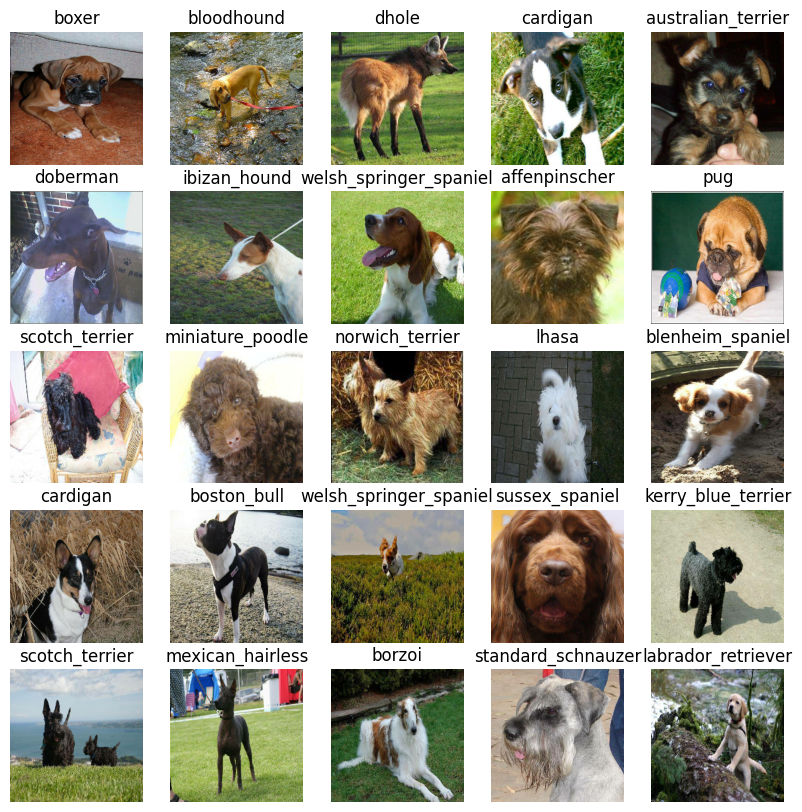

In [ ]:
#Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator()) #this make the shuffle works 'cause we shuffle the train set in the function above
show_25_images(train_images, train_labels)

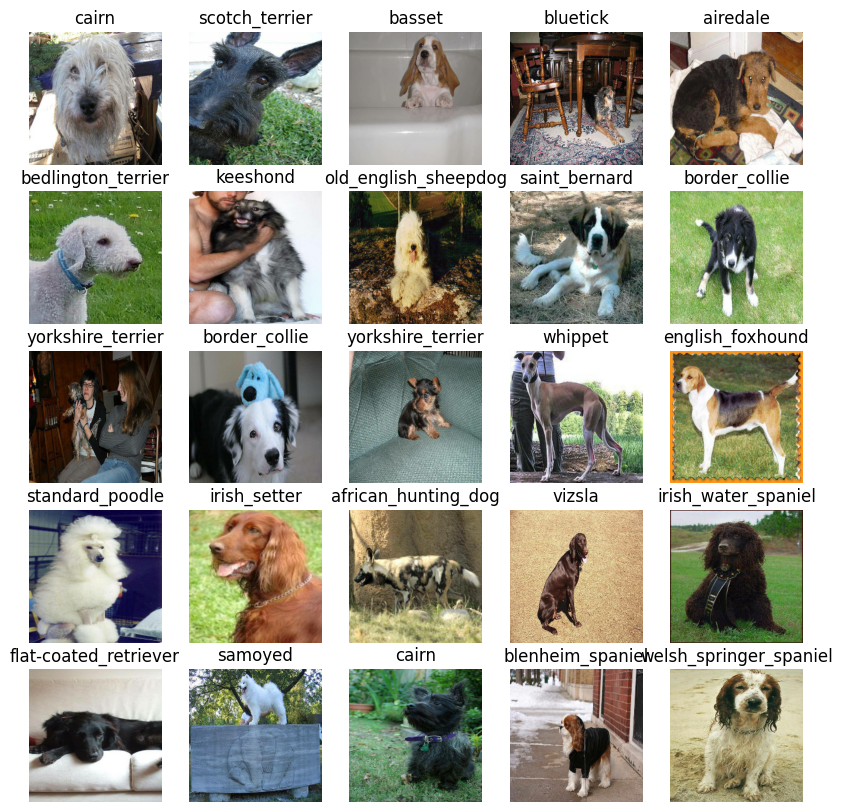

In [ ]:
#Now let's visualize the data in the validation batch
val_images, val_labels = next(val_data.as_numpy_iterator()) # this doesn't shuffle 'cause we didn't shuffle the val data in the function above
show_25_images(val_images, val_labels)

# Building a Model

Before we build a model, there are a few things we need to define:

* The input shape (our images shape, in the form of Tensor) to our model.
* The output shape (image labels, in the form of Tensor) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://www.kaggle.com/api/v1/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2/download

In [ ]:
IMG_SIZE

224

In [ ]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, colour channels

# setup the output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# setup model URL from TensorFlow Hub
MODEL_URL = "https://www.kaggle.com/api/v1/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2/download"

Now we've got our inputs, outputs and model ready to go.

Let's put them together into a Keras deep learning model.

### **Knowing this let's create a function which**:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting) (`m.build`)
* Returns the model

All these steps can be found here: https://www.tensorflow.org/guide/keras

In [ ]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  #setup the model layers
  model = tf.keras.Sequential([ # A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
      hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,  # utilizzata per creare un strato completamente connesso (o strato densamente connesso) in una rete neurale.
                            activation="softmax") #if working with binary classification: activation Sigmoid, for multi-class classification: Softmax
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), #The purpose of loss functions is to compute the quantity that a model should seek to minimize during training.
                                                      #"Cross Entrompy" è usata per i classificatori, "categorical" perchè ci sono più categorie, "sparse" quando ho codificato le categorie come interi.
                                                      #Per i casi di regressione è usata la MSE
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"] # A metric is a function that is used to judge the performance of your model.
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model



In [ ]:
model = create_model()
model.summary()

Building model with: https://www.kaggle.com/api/v1/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2/download
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


* MOBILENET_V2 REVIEW: https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c

* GUIDE TO CONVOLUTIONAL NEURAL NETWORKS (CNN): https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
The role of ConvNet is to reduce the images into a form that is easier to process, without losing features that are critical for getting a good prediction.



* SOFTMAX FUNCTION: After applying softmax, each component will be in the interval
(
0
,
1
)
{\displaystyle (0,1)}, and the components will add up to 1, so that they can be interpreted as probabilities. Furthermore, the larger input components will correspond to larger probabilities.

In [ ]:
outputs=np.ones(shape=(1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

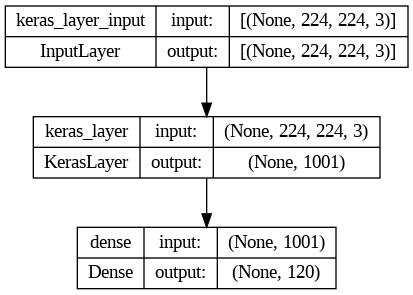

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

## Creating Callbacks

Callbacks are helper function a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long (and overfit).

### TensorBoard Callback
1. Load tensorboard (TB) extention ✅
2. create a TB ballback which is able to save logs to a directory and pass it to our model's `fit` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training)

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():

  #create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        #make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%H%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

our first model is only going to train on 1000 images, to make sure everything is working.


In [ ]:
NUM_EPOCHS= 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU not available


Let's create a function which trains a model.

* Create a model using create_model()
* Setup a TensorBoard callback using create_tensorboard_callback()
* Call the fit() function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://www.kaggle.com/api/v1/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2/download
Epoch 1/100
25/25 [==============================] - 288s 8s/step - loss: 4.5135 - accuracy: 0.1000 - val_loss: 3.5529 - val_accuracy: 0.2550
Epoch 2/100
25/25 [==============================] - 68s 3s/step - loss: 1.6110 - accuracy: 0.7013 - val_loss: 2.2620 - val_accuracy: 0.4850
Epoch 3/100
25/25 [==============================] - 91s 4s/step - loss: 0.5715 - accuracy: 0.9337 - val_loss: 1.7377 - val_accuracy: 0.5250
Epoch 4/100
25/25 [==============================] - 65s 3s/step - loss: 0.2533 - accuracy: 0.9862 - val_loss: 1.5561 - val_accuracy: 0.5950
Epoch 5/100
25/25 [==============================] - 62s 3s/step - loss: 0.1489 - accuracy: 0.9975 - val_loss: 1.4640 - val_accuracy: 0.6000
Epoch 6/100
25/25 [==============================] - 75s 3s/step - loss: 0.1005 - accuracy: 1.0000 - val_loss: 1.4110 - val_accuracy: 0.6300
Epoch 7/100
25/25 [==========

It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

## Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

# Making and evaluating predictions using a trained model

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 31s 2s/step


array([[7.9546834e-04, 5.4793563e-05, 4.4014180e-04, ..., 1.4089803e-04,
        2.9525159e-05, 8.4941089e-03],
       [5.0715212e-04, 5.4965599e-04, 1.7330289e-02, ..., 2.3403068e-04,
        1.4027440e-03, 1.1822780e-04],
       [1.4196662e-06, 4.6738984e-05, 3.0909512e-06, ..., 1.2964065e-05,
        1.4603314e-05, 3.9776810e-06],
       ...,
       [2.1407041e-05, 1.3627928e-04, 3.9250733e-04, ..., 1.0218495e-04,
        1.2862832e-04, 2.3341768e-04],
       [2.9382652e-03, 1.8598595e-05, 2.6927677e-05, ..., 3.3723700e-04,
        2.7118462e-05, 2.9013194e-03],
       [1.7469701e-04, 7.2544717e-05, 1.5073747e-03, ..., 1.8811069e-03,
        2.4381585e-03, 4.5373170e-05]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
len(unique_breeds)

120

In [ ]:
len(y_val)

200

In [ ]:
predictions[0]

array([7.95468339e-04, 5.47935633e-05, 4.40141797e-04, 3.32886630e-05,
       4.43322584e-04, 7.20222670e-06, 1.86271779e-02, 2.94799887e-04,
       5.32511658e-05, 1.89177576e-04, 2.77050451e-04, 2.91512813e-04,
       1.42022414e-04, 5.64992115e-05, 1.05584317e-04, 5.72643243e-04,
       1.17220625e-05, 3.56735617e-01, 1.18306752e-05, 9.66382431e-05,
       5.77238563e-04, 5.39490575e-05, 5.16086620e-05, 1.96034485e-03,
       3.01995406e-05, 1.42040211e-04, 1.16222933e-01, 6.31493967e-05,
       1.51166355e-03, 1.06121573e-04, 1.14364600e-04, 2.97206547e-03,
       7.15780130e-04, 3.41499799e-05, 4.37020717e-05, 1.40201813e-02,
       6.01057354e-06, 3.73125484e-04, 3.83557417e-05, 1.01004014e-04,
       3.77635076e-03, 1.53655565e-05, 2.44439521e-04, 6.08082446e-05,
       3.31910269e-05, 9.97334573e-05, 5.93228579e-05, 3.94389317e-05,
       4.29540407e-04, 1.30989982e-04, 1.04005099e-04, 3.47510722e-05,
       9.48210800e-05, 3.15176731e-05, 1.75955662e-04, 1.78396622e-05,
      

In [ ]:
# First prediction
index = 42
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}") #finding the max value in the predictions
print(f"Sum: {np.sum(predictions[index])}") #sum of all the predictions in the index 42
print(f"Max index: {np.argmax(predictions[index])}") #stampa l'indice con la massima probabilità
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}") #stampa l'etichetta predetta

[2.15311975e-05 1.10027409e-04 6.81382744e-06 6.01270294e-05
 5.34528540e-03 1.02153776e-04 3.65027459e-04 9.43543855e-04
 5.77031868e-03 4.53338176e-02 1.00382176e-05 7.68082464e-06
 1.73891283e-04 1.36678410e-03 8.55839971e-05 9.48042085e-04
 1.28736821e-04 4.52044507e-04 1.66433922e-04 4.39530791e-04
 3.59277401e-05 5.51288831e-04 4.40612966e-05 2.99595504e-05
 4.62731766e-03 3.93597220e-05 8.43975577e-05 2.75579750e-05
 8.06004449e-04 1.95184348e-05 2.44594085e-05 3.09019015e-05
 6.00322055e-05 2.88524279e-05 6.84203987e-05 1.14448876e-05
 2.04669981e-04 2.38411973e-04 6.85582127e-05 1.12238504e-01
 1.18663185e-04 5.26100375e-05 9.08707967e-04 6.86074327e-06
 2.33302417e-04 9.98083196e-05 6.00724423e-04 1.06193847e-03
 4.11278088e-05 3.23141750e-04 3.14134522e-05 4.66089332e-05
 1.13932627e-04 4.61625680e-03 1.72727043e-04 4.34989663e-04
 5.88112336e-04 3.89451525e-05 6.27511254e-05 1.66855480e-05
 6.04703928e-05 1.05128461e-03 3.60114063e-05 1.89731127e-05
 3.01335851e-04 8.944294

In [ ]:
unique_breeds[113]

'walker_hound'

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note**: Prediction probabilities are also known as confidence levels.

In [ ]:

# Turn prediction probabilities into their respective label (easier to understand)
#turn into a function the code above
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'


Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get get:

* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaulize.

We'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

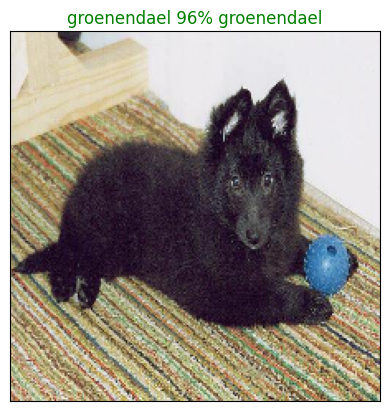

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

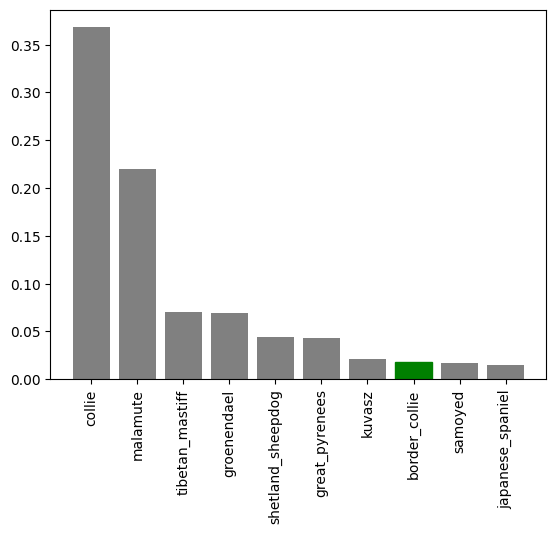

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

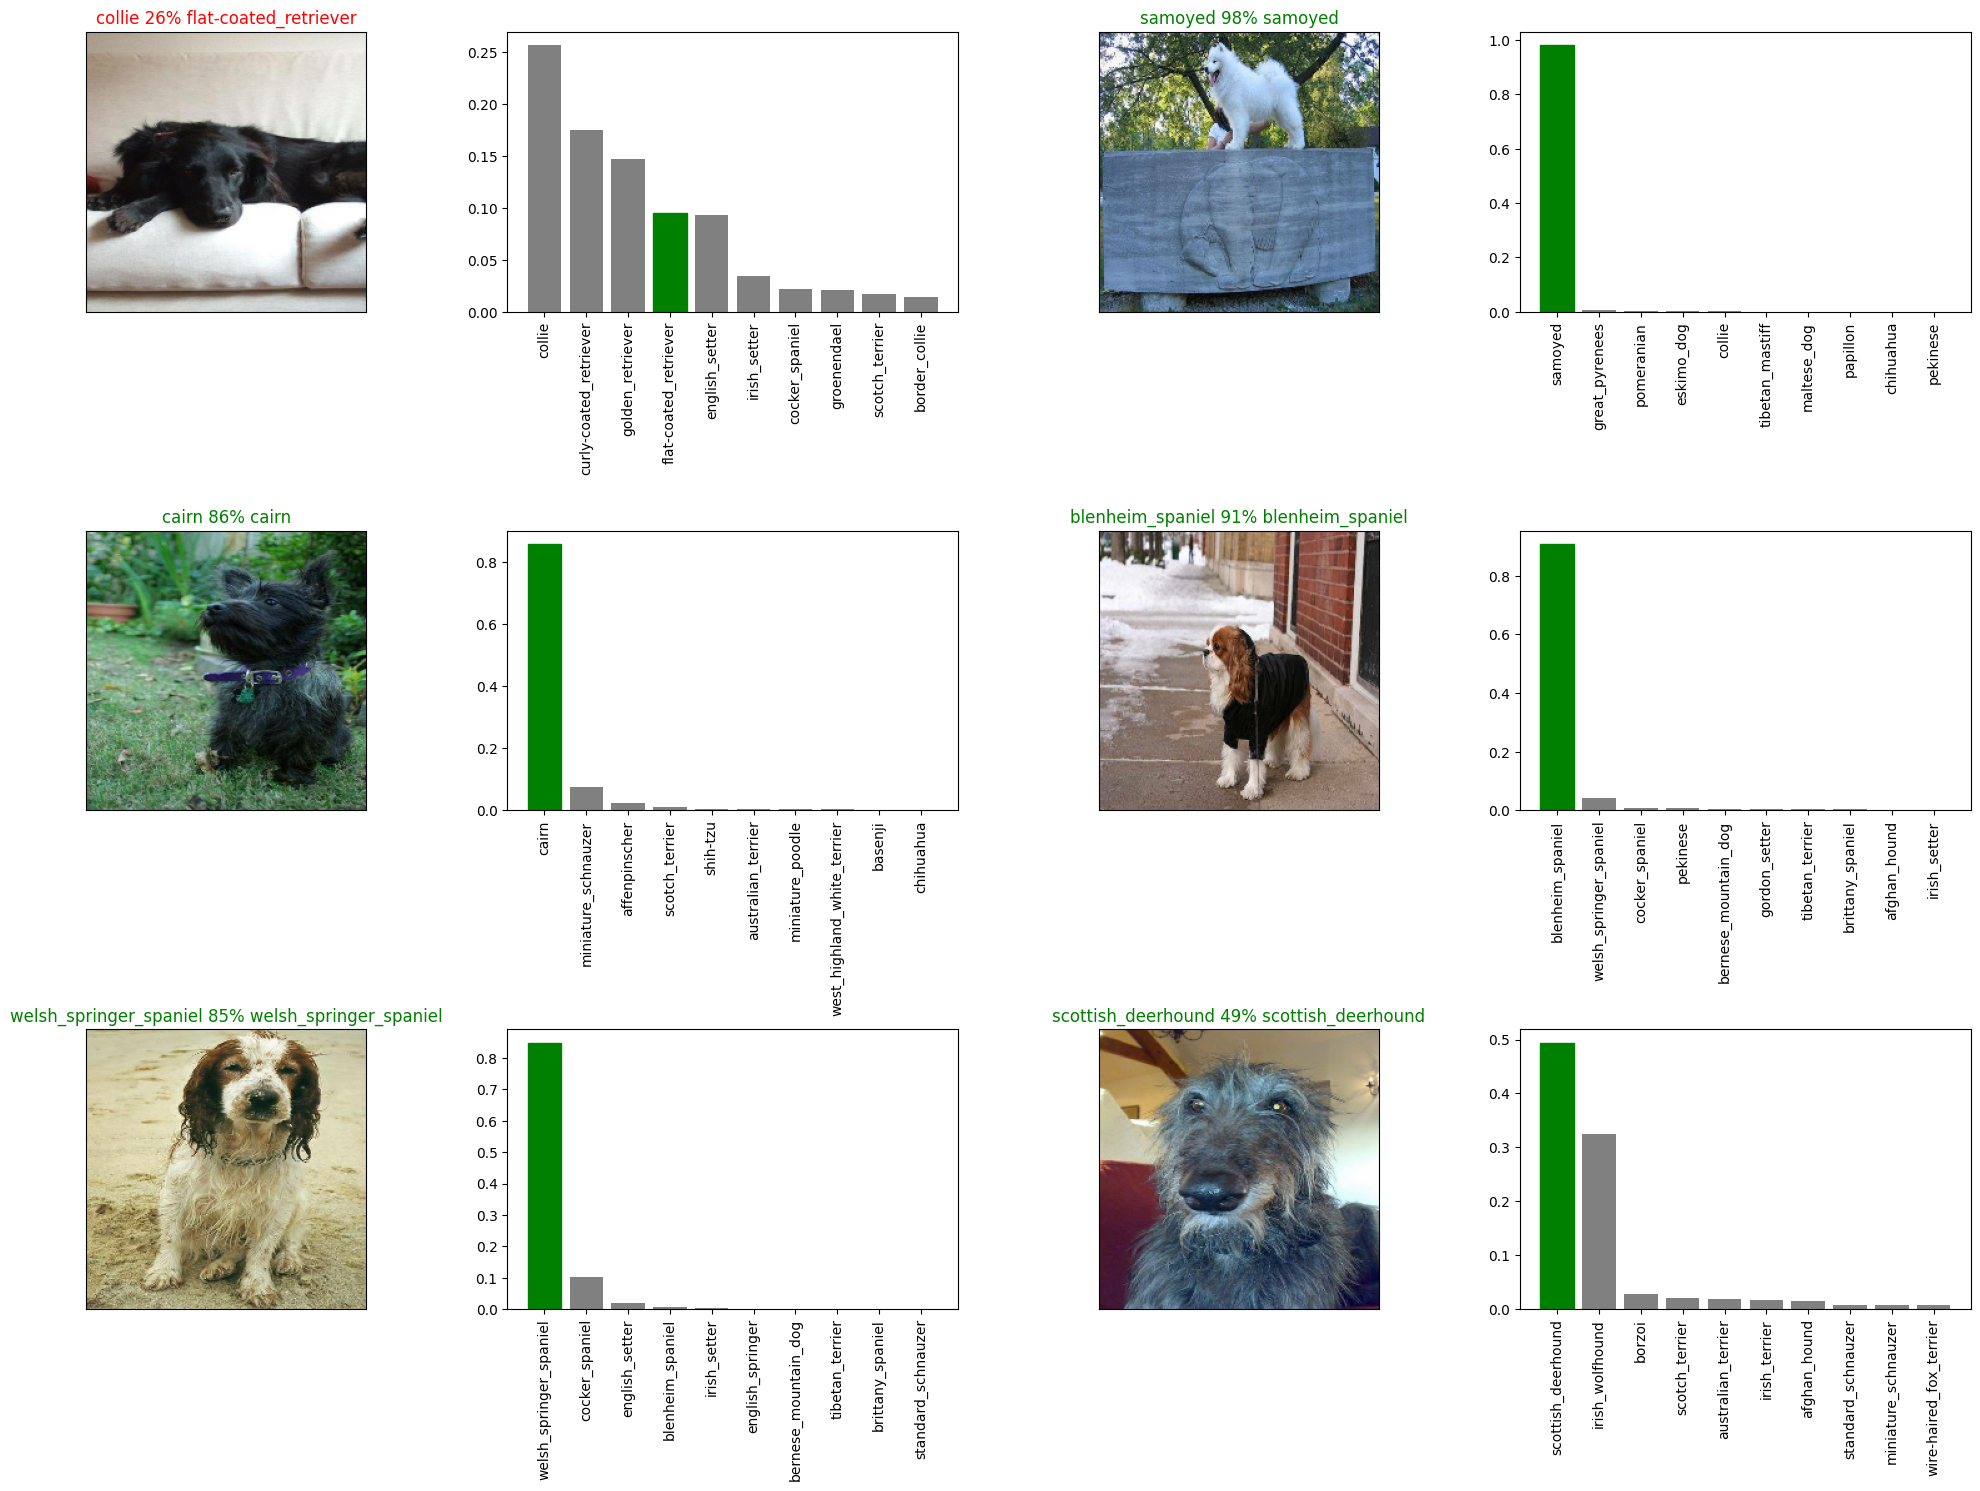

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

In [ ]:
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

# Saving and reloading a model

After training a model, it's a good idea to save it. Saving it means you can share it with colleagues, put it in an application and more importantly, won't have to go through the potentially expensive step of retraining it.

The format of an [entire saved Keras model is h5](https://www.tensorflow.org/tutorials/keras/save_and_load). So we'll make a function which can take a model as input and utilise the save() method to save it as a h5 file to a specified directory.

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/MyDrive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

If we've got a saved model, we'd like to load it, let's create a function which can take a model path and use the tf.keras.models.load_model() function to load it into the notebook.

Because we're using a component from TensorFlow Hub (hub.KerasLayer) we'll have to pass this as a parameter to the custom_objects parameter.

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: drive/MyDrive/Data/models/20240620-16281718900927-1000-images-Adam.h5...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'drive/MyDrive/Data/models/20240620-16281718900927-1000-images-Adam.h5'

In [ ]:
# Load our model trained on 1000 images
model_1000_images = load_model('drive/MyDrive/Data/models/20240613-13561718286961-1000-images-Adam.h5')

Loading saved model from: drive/MyDrive/Data/models/20240613-13561718286961-1000-images-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 10s 1s/step - loss: 1.2685 - accuracy: 0.6800


[1.2685141563415527, 0.6800000071525574]

In [ ]:
# Evaluate the loaded model
model_1000_images.evaluate(val_data)

7/7 [==============================] - 12s 1s/step - loss: 1.2386 - accuracy: 0.6900


[1.238572597503662, 0.6899999976158142]

# Training a model (on the full data)

Now we know our model works on a subset of the data, we can start to move forward with training one on the full data.

Above, we saved all of the training filepaths to X and all of the training labels to y. Let's check them out.

In [ ]:
# Remind ourselves of the size of the full dataset
len(X), len(y)

(10222, 10222)

There we go! We've got over 10,000 images and labels in our training set.

Before we can train a model on these, we'll have to turn them into a data batch.

The beautiful thing is, we can use our create_data_batches() function from above which also preprocesses our images for us (thank you past us for writing a helpful function).

In [ ]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batches...


Our data is in a data batch, all we need now is a model.

And surprise, we've got a function for that too! Let's use create_model() to instantiate another model.

In [ ]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with: https://www.kaggle.com/api/v1/models/google/mobilenet-v2/tensorFlow2/130-224-classification/2/download


Since we've made a new model instance, full_model, we'll need some callbacks too.



In [ ]:
# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accruacy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

To monitor the model whilst it trains, we'll load TensorBoard (it should update every 30-seconds or so whilst the model trains).

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

Note: Since running the cell below will cause the model to train on all of the data (10,000+) images, it may take a fairly long time to get started and finish. However, thanks to our full_model_early_stopping callback, it'll stop before it starts going too long.

Remember, the first epoch is always the longest as data gets loaded into memory. After it's there, it'll speed up.

In [ ]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard,
                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 607s 2s/step - loss: 1.3271 - accuracy: 0.6726
Epoch 2/100
320/320 [==============================] - 591s 2s/step - loss: 0.3998 - accuracy: 0.8839
Epoch 3/100
320/320 [==============================] - 588s 2s/step - loss: 0.2344 - accuracy: 0.9362
Epoch 4/100
320/320 [==============================] - 585s 2s/step - loss: 0.1543 - accuracy: 0.9641
Epoch 5/100
320/320 [==============================] - 579s 2s/step - loss: 0.1053 - accuracy: 0.9780
Epoch 6/100
316/320 [============================>.] - ETA: 7s - loss: 0.0775 - accuracy: 0.9863

#Saving and reloading the full model

Even on a GPU, our full model took a while to train. So it's a good idea to save it.

We can do so using our save_model() function.

In [ ]:
# Save the model to file
save_model(full_model, suffix="all-images-Adam")

In [ ]:
# Load in the full model
loaded_full_model = load_model('drive/MyDrive/Data/models/20240620-11281718882895-all-images-Adam.h5')

#Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we `created create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames.
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the predict() function.


In [ ]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
# Carica i dati di test escludendo la directory .ipynb_checkpoints
test_path = "drive/MyDrive/Dog Vision/test/"
test_filenames = [os.path.join(test_path, f) for f in os.listdir(test_path) if not f.startswith('.ipynb_checkpoints')]
test_filenames[:10]

In [ ]:
# How mant test images are there?
len(test_filenames)

In [ ]:
# create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

In [ ]:

# # Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [ ]:
# Load predictions (NumPy array) from csv file
#test_predictions= np.loadtxt("drive/MyDrive/Dog Vision/preds_array.csv", delimiter=",")

In [ ]:
test_predictions[:10]

In [ ]:
# Save predictions to cvs file for access later
np.savetxt("drive/MyDrive/Dog Vision/", test_predictions, delimiter=","

# Preparing test dataset predictions for Kaggle

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns using the unique_breeds list and the test_predictions list.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# Create pandas DataFrame with empty columns
preds_df=pd.DataFrame(columns=["id"]+ list(unique_breeds))
preds_df.head()

In [ ]:
# append test image ID's to prediction DataFrame
test_path = "drive/MyDrive/Dog Vision/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

In [ ]:
# Add prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
pred_df.to_csv("drive/MyDrive/Data/full_submission_1_mobilenetV2_adam.csv",
               index=False)

#Making predictions on custom images
* Get the filepaths of our own images.
* Turn the filepaths into data batches using create_data_batches(). And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's predict() method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get custom image filepaths
custom_path = "drive/My Drive/Data/dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

In [ ]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)